In [36]:
import pandas as pd

In [37]:
# Import the data set:
train_data = pd.read_csv('Dataset/Train_60/Train_60/Training.csv')
test_data = pd.read_csv('Dataset/Test_20/Test_20/Testing.csv')

In [38]:
# Shape of the data:
print("Training data: ", train_data.shape) 
print("Testing data: ", test_data.shape) 

Training data:  (785133, 22)
Testing data:  (261712, 22)


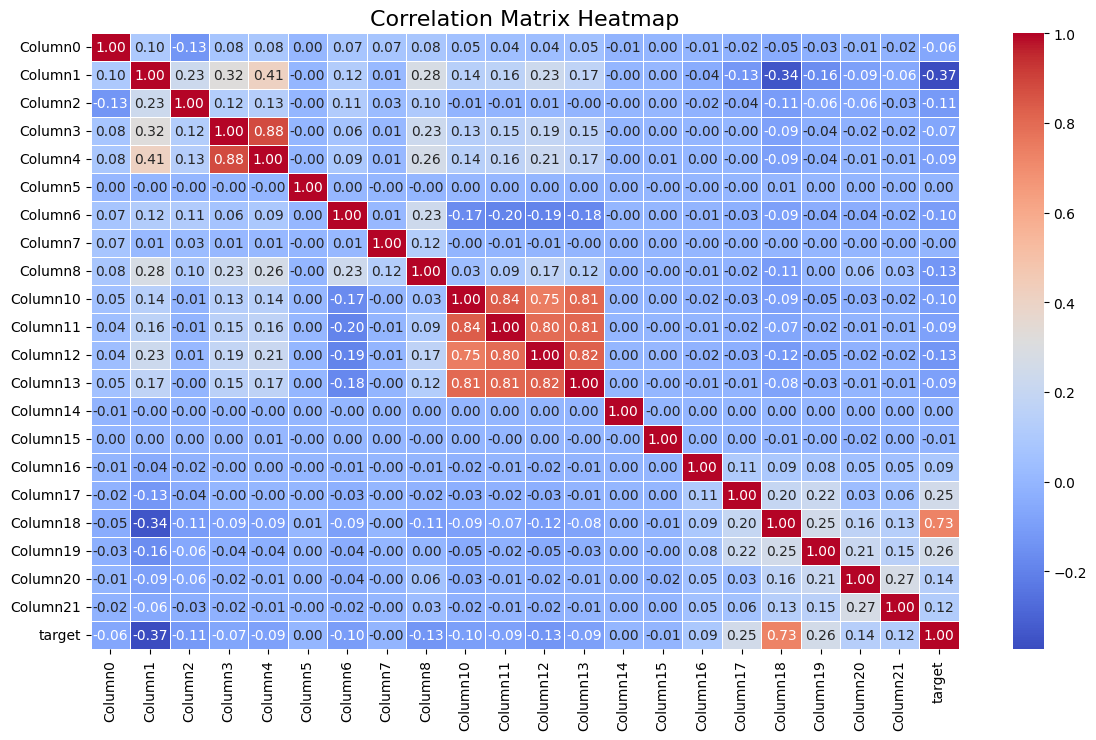

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = train_data.corr()

plt.figure(figsize=(14, 8)) 
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

### Filter out the columns which are having least impact on target

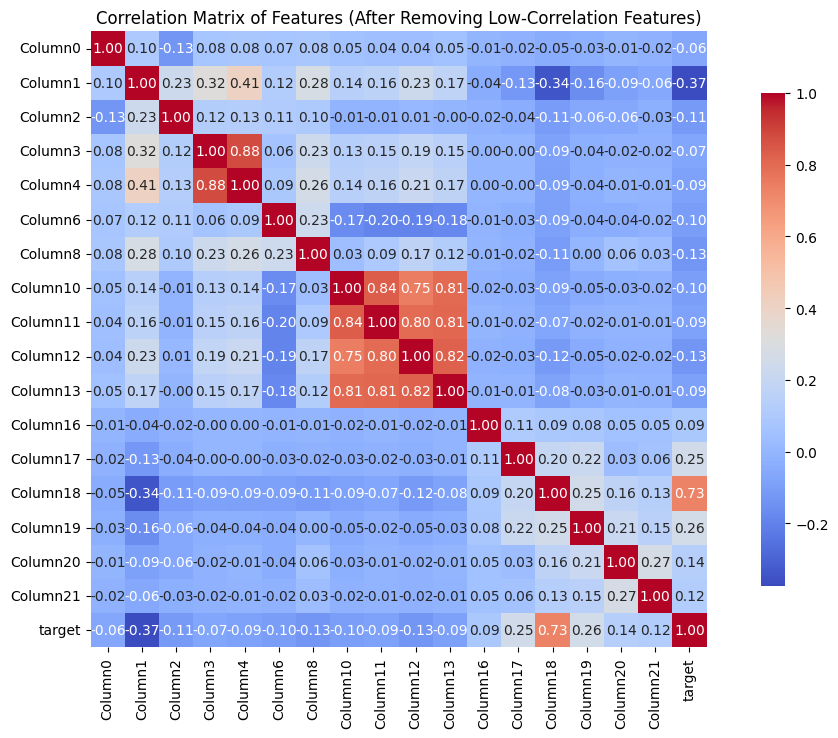

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(train_data)

# Calculate the absolute correlation of features with the target
correlation_threshold = 0.01  
correlation_matrix = df.corr()
target_correlation = correlation_matrix['target'].abs()

# Select features with correlation higher than the threshold
features_to_keep = target_correlation[target_correlation > correlation_threshold].index.tolist()

# Drop low-correlation features
reduced_df = df[features_to_keep]

# Calculate the correlation matrix for the reduced DataFrame
reduced_correlation_matrix = reduced_df.corr()


plt.figure(figsize=(14, 8))
sns.heatmap(reduced_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set title
plt.title("Correlation Matrix of Features (After Removing Low-Correlation Features)")
plt.show()

In [42]:
train_data = reduced_df
test_data = test_data[features_to_keep]

In [43]:
print(train_data.shape)
print(test_data.shape)

(785133, 18)
(261712, 18)


In [44]:
train_data['target'].value_counts()

target
0    711100
1     74033
Name: count, dtype: int64

In [45]:
test_data['target'].value_counts()

target
0    237034
1     24678
Name: count, dtype: int64

### Handle the class imbalance

In [46]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state= 42)

X_train = train_data.drop('target', axis=1)
y_train = train_data['target']

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [47]:
from collections import Counter

# Count the occurrences of each class (0s and 1s) in y_train_smote
class_counts = Counter(y_train_smote)
print(class_counts)

Counter({0: 711100, 1: 711100})


In [48]:
X_train = X_train_smote
y_train = y_train_smote

In [49]:
X_test = test_data.drop('target', axis=1)
y_test = test_data['target']

### Neural Network

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# Initialize the model
model = Sequential()

# Input layer (use Input layer to define input shape)
model.add(Input(shape=(X_train_scaled.shape[1],)))

# Add hidden layers
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.3))  # Dropout layer to reduce overfitting

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

# Output layer (for binary classification)
model.add(Dense(1, activation='sigmoid'))

In [20]:
from tensorflow.keras.optimizers import Adam

# Compile the model using Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with validation split (e.g., 80% train and 20% validation)
history = model.fit(X_train_scaled, y_train_smote,
                    validation_split=0.2,  # Use 20% of training data for validation
                    epochs=100,            # You can change this based on performance
                    batch_size=64,
                    class_weight={0: 1.0, 1: 2.5},
                    callbacks=[early_stopping])

Epoch 1/100
17778/17778 ━━━━━━━━━━━━━━━━━━━━ 9s 495us/step - accuracy: 0.9324 - loss: 0.2232 - val_accuracy: 1.0000 - val_loss: 0.0191
Epoch 2/100
17778/17778 ━━━━━━━━━━━━━━━━━━━━ 9s 488us/step - accuracy: 0.9758 - loss: 0.0972 - val_accuracy: 1.0000 - val_loss: 0.0184
Epoch 3/100
17778/17778 ━━━━━━━━━━━━━━━━━━━━ 9s 507us/step - accuracy: 0.9759 - loss: 0.0945 - val_accuracy: 1.0000 - val_loss: 0.0189
Epoch 4/100
17778/17778 ━━━━━━━━━━━━━━━━━━━━ 9s 490us/step - accuracy: 0.9764 - loss: 0.0909 - val_accuracy: 0.9999 - val_loss: 0.0208
Epoch 5/100
17778/17778 ━━━━━━━━━━━━━━━━━━━━ 9s 489us/step - accuracy: 0.9766 - loss: 0.0892 - val_accuracy: 0.9999 - val_loss: 0.0155
Epoch 6/100
17778/17778 ━━━━━━━━━━━━━━━━━━━━ 9s 489us/step - accuracy: 0.9768 - loss: 0.0882 - val_accuracy: 0.9994 - val_loss: 0.0202
Epoch 7/100
17778/17778 ━━━━━━━━━━━━━━━━━━━━ 9s 493us/step - accuracy: 0.9773 - loss: 0.0863 - val_accuracy: 0.9996 - val_loss: 0.0166
Epoch 8/100
17778/17778 ━━━━━━━━━━━━━━━━━━━━ 9s 494us/s

In [22]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 1s 178us/step - accuracy: 0.9674 - loss: 0.0986
Test Loss: 0.09681229293346405
Test Accuracy: 0.9677355289459229


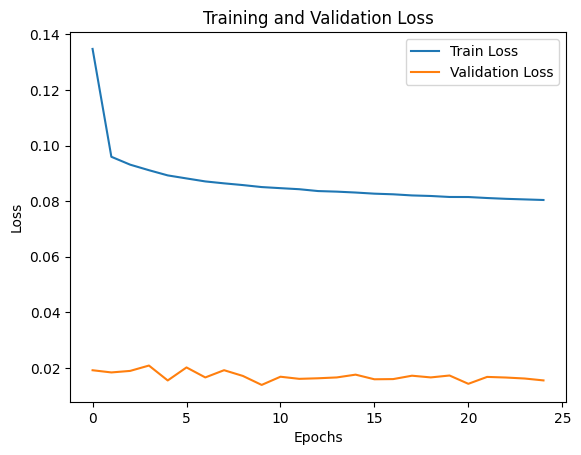

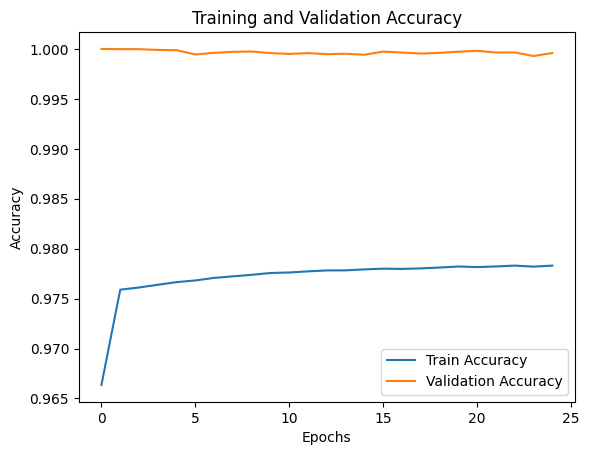

In [35]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

8179/8179 ━━━━━━━━━━━━━━━━━━━━ 2s 198us/step
AUC-ROC: 0.992151937021912


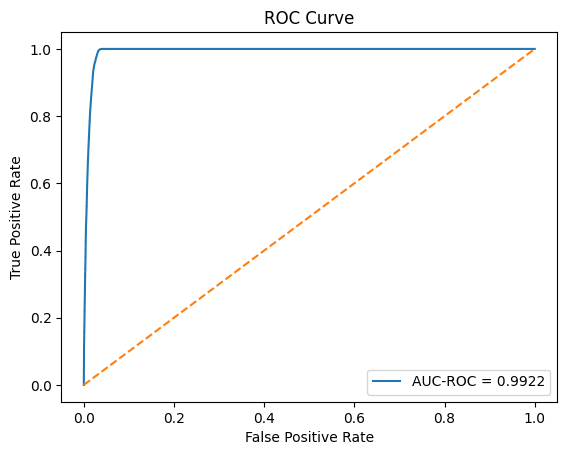

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_proba = model.predict(X_test_scaled).ravel()

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc}")

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')  # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

# Binary classification predictions
y_pred_class = (y_pred_proba > 0.5).astype(int)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print(f"Confusion Matrix:\n{conf_matrix}")

# Classification report
report = classification_report(y_test, y_pred_class)
print(f"Classification Report:\n{report}")

Confusion Matrix:
[[228627   8407]
 [    37  24641]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    237034
           1       0.75      1.00      0.85     24678

    accuracy                           0.97    261712
   macro avg       0.87      0.98      0.92    261712
weighted avg       0.98      0.97      0.97    261712



In [34]:
# Select a row from the DataFrame (for example, the first row)
row = X_test.iloc[203]  # Replace with any index of your choice

# Convert the row to a DataFrame format suitable for the scaler
row = row.values.reshape(1, -1)

# Scale the selected row using the same scaler used for training
row_scaled = scaler.transform(row)

# Make prediction
prediction = model.predict(row_scaled)

# Output the prediction
if prediction >= 0.5:
    print("Predicted Class: 1")
else:
    print("Predicted Class: 0")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted Class: 0


/Users/princekumar/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
